In [1]:
from frozen_lake import *
env = FrozenLakeEnvSequentialMultigoal(goal=2)
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S   : starting point, safe
    F   : frozen surface, safe
    H   : hole, fall to your doom
    1|2 : goal for agent 1 or agent 2

    The episode ends when you reach the all the goals for a corresponding agent.
    You receive a reward of 1 each time you reach a goal, and zero otherwise.

    


In [2]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
%matplotlib inline

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)

NUM_ITER = 75
GAMMA = 0.95

In [3]:
class MDP(object):
    def __init__(self, env):
        P, nS, nA, desc = MDP.env2mdp(env)
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
        self.env = env

    def env2mdp(env):
        return {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc
    
    def get_transition_matrix(self):
        """Return a matrix with index S,A,S' -> P(S'|S,A)"""
        T = np.zeros([self.nS, self.nA, self.nS])
        for s in range(self.nS):
            for a in range(self.nA):
                transitions = self.P[s][a]
                s_a_s = {t[1]:t[0] for t in transitions}
                for s_prime in range(self.nS):
                    if s_prime in s_a_s:
                        T[s, a, s_prime] = s_a_s[s_prime]
        return T
    
mdp = MDP(env)

In [4]:
def compute_traj_likelihood(mdp, traj, actions):
    """
    Naive likelihood calculation. Should work ok for simple gridworld with short trajectories
    """
    transitions = [(traj[i], actions[i], traj[i+1]) for i in range(len(traj)-1)]
    likelihood = 1.0
    for s,a,s_prime in transitions:
        t = mdp.P[s][a]
        transition_prob = 0.0
        for p, nextstate, _ in t:
            if nextstate == s_prime:
                transition_prob = p
        likelihood *= transition_prob
    return likelihood

In [25]:
def compute_Q(T_s, V, gamma):
            Q = {}
            for a in T_s:
                Q_sa = sum(
                    [sas[0]*(sas[2] + gamma*V[sas[1]]) for sas in T_s[a]])
                Q[a] = Q_sa
            return Q

def compute_mixed_Q(T1_s, T2_s, w1, w2, V, gamma):
            Q = {}
            for a in T1_s:
                Q_sa = 0.0
                for i in range(len(T1_s[a])):
                    sas1 = T1_s[a][i]
                    sas2 = T2_s[a][i]
                    Q_sa += sas1[0]*(w1*sas1[2] + w2*sas2[2] + gamma*V[sas1[1]])
                Q[a] = Q_sa
            return Q

def compute_values(mdp1, mdp2, w1, w2, gamma, nIt):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
        
    len(value_functions) == nIt+1 and len(policies) == n
    """
    Vs = [np.zeros(mdp1.nS)] # list of value functions contains the initial value function, which is zero
    pis = []
    for it in range(nIt):
        Vprev = Vs[-1]        
        
        # Your code should define variables V: the bellman backup applied to Vprev
        # and pi: the greedy policy applied to Vprev
        
        
        V = np.zeros(mdp1.nS)
        pi = np.zeros(mdp1.nS)

        for s in range(mdp1.nS):
            Q = compute_mixed_Q(mdp1.P[s], mdp2.P[s], w1, w2, Vprev, gamma)
            V[s] = max(Q.values())
            pi[s] = max(Q, key=lambda x:Q[x])
        Vs.append(V)
        pis.append(pi)
        
#     pi = np.zeros(mdp1.nS)
#     for s in range(mdp1.nS):
# #         Q = compute_Q(mdp1.P[s], Vs[-1], gamma)
#         pi[s] = 

    return Vs[-1], pis[-1]
    
    
def mix_values(V1, V2, mdp1, mdp2, w1=1.0, w2=1.0, gamma=GAMMA):
    V = np.zeros(mdp1.nS)
    pi = np.zeros(mdp1.nS)
    for s in range(mdp1.nS):
        Q1_s = compute_Q(mdp1.P[s], V1, gamma)
        Q2_s = compute_Q(mdp2.P[s], V2, gamma)
        mixed_q_s = {a: w1*Q1_s[a] + w2*Q2_s[a] for a in Q1_s}
        V[s] = max(mixed_q_s.values())
        pi[s] = max(mixed_q_s, key=lambda x:mixed_q_s[x])
    return V, pi

In [28]:
def normalize(*args):
    normalized = []
    total = sum(args)
    for arg in args:
        normalized.append(arg / total)
    return tuple(normalized)

def plot_values(V, pi, s):
    V = V[:-1]
    goals = s % 16
    goal_inds = [i for i in range(len(V)) if i % 16 == goals]
    V = V[goal_inds]
    V /= max(V)
    pi = pi[goal_inds]
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(9,9), cmap='gray', interpolation='none', aspect='auto', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(9)-.5)
    ax.set_yticks(np.arange(9)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:9, 0:9]
    a2uv = {0:(-1, 0), 1:(0, -1), 2:(1, 0), 3:(0, 1),
            4:(-1, 1), 5:(-1, -1), 6:(1, -1), 7:(1, 1),
            8:(0, 0)}
    Pi = pi.reshape(9,9)
    for y in range(9):
        for x in range(9):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    
    if s != (9 * 9 * 16):
        plt.plot((s >> 4)%9, (s >> 4)//9, 'ro')
    plt.grid(color='b', lw=2, ls='-')
    plt.show()
    
def run_mixing_agent(true_mdp, mdp1, mdp2, p1=1.0, p2=1.0, GAMMA=GAMMA, vis=plot_values):
    true_mdp.env.reset()
    s1 = mdp1.env.reset()
    s2 = mdp2.env.reset()
    assert s1 == s2, "mdp state spaces must be the same"
    s, done = s1, False
    
    Vs = []
    pi = np.zeros(mdp1.nS)
    
    w1, w2 = normalize(p1, p2)
    traj, actions = [s,], []
    V, pi = compute_values(mdp1, mdp2, w1, w2, GAMMA, 199)

    while not done:
#         V, pi = mix_values(V1, V2, mdp1, mdp2, w1, w2, GAMMA)
        action = pi[s]
        s, _, done, _ = true_mdp.env.step(action)
        traj.append(s)
        actions.append(action)
#         l1, l2 = compute_traj_likelihood(mdp1, traj, actions), compute_traj_likelihood(mdp2, traj, actions)
#         w1, w2 = normalize(p1*l1, p2*l2)
        if vis:
            vis(V, pi, s)
        print("{0:b}".format(s))
    return traj

In [18]:
mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1))
mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2))
true_mdp = MDP(FrozenLakeEnvSequentialMultigoal(goal=1))

traj = run_mixing_agent(true_mdp, mdp1, mdp2, p1=1.0, p2=1.0, GAMMA=1.0)

KeyboardInterrupt: 

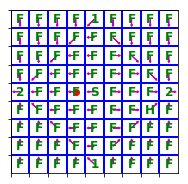

1001110000


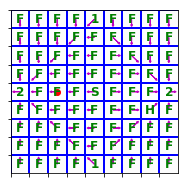

1001100000


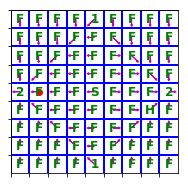

1001010000


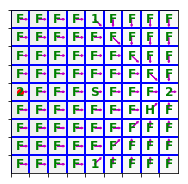

1001000010


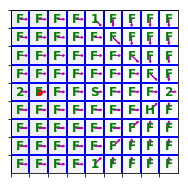

1001010010


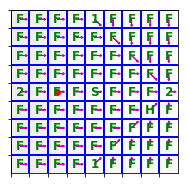

1001100010


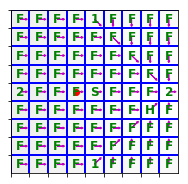

1001110010


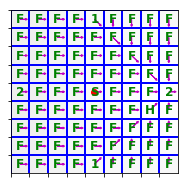

1010000010


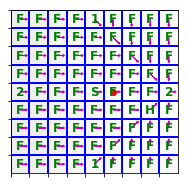

1010010010


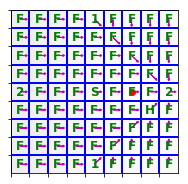

1010100010


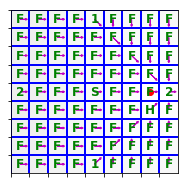

1010110010


/Users/nishant/Projects/irl/frozenlake/venv/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


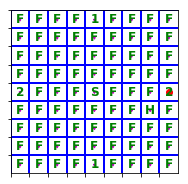

1011000110


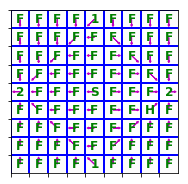

10100010000


In [29]:
traj = run_mixing_agent(true_mdp, mdp1, mdp2, p1=0.0, p2=1.0, GAMMA=1.0)

In [12]:
traj

[640, 1296]